# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# import libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as F 
from pyspark.sql.functions import isnan, when, count, col, udf,from_unixtime
from pyspark.sql.types import IntegerType,StringType,LongType, DateType, TimestampType
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier,GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# create a Spark session
spark = SparkSession\
        .builder\
        .appName('sparkify churn prediction')\
        .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
df = spark.read.json('mini_sparkify_event_data.json')

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Create a temporary view against which you can run SQL queries.

In [6]:
df.createOrReplaceTempView("user_log_table")

In [5]:
spark.sql("SELECT * FROM user_log_table LIMIT 2").show()

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   Canada|   200|1538352180000|"Moz

In [8]:
spark.sql("SELECT DISTINCT page FROM user_log_table ORDER BY 1").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



In [9]:
# check missing values in userId column
spark.sql("SELECT userId,COUNT(*) AS num FROM user_log_table GROUP BY userId ORDER BY 1").show()

+------+----+
|userId| num|
+------+----+
|      |8346|
|    10| 795|
|   100|3214|
|100001| 187|
|100002| 218|
|100003|  78|
|100004|1245|
|100005| 216|
|100006|  44|
|100007| 520|
|100008| 940|
|100009| 671|
|100010| 381|
|100011|  23|
|100012| 600|
|100013|1392|
|100014| 310|
|100015|1050|
|100016| 638|
|100017|  75|
+------+----+
only showing top 20 rows



In [9]:
# check missing values in sessionId column
spark.sql("SELECT sessionId, COUNT(*) AS num FROM user_log_table GROUP BY sessionId ORDER BY 1").show()

+---------+---+
|sessionId|num|
+---------+---+
|        1|714|
|        2|  7|
|        3| 38|
|        4| 24|
|        5| 58|
|        6| 71|
|        7|  1|
|        8| 49|
|        9|197|
|       10|176|
|       11| 47|
|       12| 60|
|       13|122|
|       15|220|
|       16| 39|
|       17|171|
|       18| 30|
|       19|158|
|       20| 29|
|       21|138|
+---------+---+
only showing top 20 rows



8346 rows have missing userId. No missing values exist in sessionId column.

In [7]:
# Remove rows with missing userId
user_log_valid = df.filter(df['userId']!='')

In [12]:
df.count()

286500

In [13]:
user_log_valid.count()

278154

In [17]:
user_log_valid.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in user_log_valid.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [22]:
user_log_valid.select(["artist", "page", "song"]).where(user_log_valid.artist.isNull()).dropDuplicates().collect()

[Row(artist=None, page='Cancel', song=None),
 Row(artist=None, page='Submit Downgrade', song=None),
 Row(artist=None, page='Thumbs Down', song=None),
 Row(artist=None, page='Home', song=None),
 Row(artist=None, page='Downgrade', song=None),
 Row(artist=None, page='Roll Advert', song=None),
 Row(artist=None, page='Logout', song=None),
 Row(artist=None, page='Save Settings', song=None),
 Row(artist=None, page='Cancellation Confirmation', song=None),
 Row(artist=None, page='About', song=None),
 Row(artist=None, page='Settings', song=None),
 Row(artist=None, page='Add to Playlist', song=None),
 Row(artist=None, page='Add Friend', song=None),
 Row(artist=None, page='Thumbs Up', song=None),
 Row(artist=None, page='Help', song=None),
 Row(artist=None, page='Upgrade', song=None),
 Row(artist=None, page='Error', song=None),
 Row(artist=None, page='Submit Upgrade', song=None)]

artist, length and song columns also have missing values but that's due the action is not playing songs.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [8]:
# Define churn
churn_event = udf(lambda x: 1 if x =="Cancellation Confirmation" else 0, IntegerType())

In [9]:
user_log_valid = user_log_valid.withColumn("churn",churn_event("page"))
user_log_valid.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0)

In [10]:
# churn vs not churn using SQL
user_log_valid.createOrReplaceTempView('user_log_table')

In [10]:
spark.sql('''
          SELECT churn_flag,count(DISTINCT userId) AS num_user 
          FROM (SELECT a.*, MAX(churn) OVER(PARTITION BY userId) AS churn_flag 
          FROM user_log_table a)
          GROUP BY churn_flag
          '''
          ).show()

+----------+--------+
|churn_flag|num_user|
+----------+--------+
|         1|      52|
|         0|     173|
+----------+--------+



About 1/5 users churned in the dataset.

In [11]:
spark.udf.register("get_time", lambda x: datetime.datetime.fromtimestamp(x/1000.0),TimestampType())

<function __main__.<lambda>(x)>

In [78]:
spark.sql('''
          SELECT userId,page,sessionId,get_time(ts) AS timestamp, get_time(registration) AS regis_time,level, churn
          FROM user_log_table
          WHERE userId = '30'
          '''
          ).show()

+------+---------------+---------+-------------------+-------------------+-----+-----+
|userId|           page|sessionId|          timestamp|         regis_time|level|churn|
+------+---------------+---------+-------------------+-------------------+-----+-----+
|    30|       NextSong|       29|2018-09-30 20:01:57|2018-09-28 18:22:42| paid|    0|
|    30|       NextSong|       29|2018-09-30 20:06:34|2018-09-28 18:22:42| paid|    0|
|    30|       NextSong|       29|2018-09-30 20:11:16|2018-09-28 18:22:42| paid|    0|
|    30|       NextSong|       29|2018-09-30 20:14:59|2018-09-28 18:22:42| paid|    0|
|    30|Add to Playlist|       29|2018-09-30 20:15:05|2018-09-28 18:22:42| paid|    0|
|    30|       NextSong|       29|2018-09-30 20:18:04|2018-09-28 18:22:42| paid|    0|
|    30|       NextSong|       29|2018-09-30 20:20:18|2018-09-28 18:22:42| paid|    0|
|    30|       NextSong|       29|2018-09-30 20:24:01|2018-09-28 18:22:42| paid|    0|
|    30|       NextSong|       29|2018-09-3

from the above examples, we can find same session means a series actions happened in a continuous time period. Session would change if a person does not perform any action in a certain time period.

In [74]:
# average number of songs in each session for churn and not churn users
song = spark.sql('''
          SELECT round(AVG(num_songs),2) avg_songs,churn_flag
          FROM
          (SELECT userId,sessionId,churn_flag,COUNT(page) AS num_songs
          FROM (SELECT a.*,MAX(churn) OVER(PARTITION BY userId) AS churn_flag FROM user_log_table AS a) 
          WHERE page = 'NextSong'
          GROUP BY userId,sessionId,churn_flag)
          GROUP BY churn_flag
          ''')
song.createOrReplaceTempView('song')

In [75]:
# average time spent in each session for churn and not churn users
time = spark.sql('''
          SELECT round(AVG((UNIX_TIMESTAMP(end_time)-UNIX_TIMESTAMP(start_time))/60),2) AS avg_session_time, churn_flag
          FROM
          (SELECT DISTINCT userId, sessionId,MIN(get_time(ts)) OVER(PARTITION BY userId,sessionId) AS start_time, 
          MAX(get_time(ts)) OVER(PARTITION BY userId, sessionId) AS end_time, 
          MAX(churn) OVER(PARTITION BY userId) AS churn_flag 
          FROM user_log_table)
          GROUP BY churn_flag          
          ''')
time.createOrReplaceTempView('time')

In [77]:
spark.sql('''
          SELECT *
          from song join time using(churn_flag)
          ''').show()

+----------+---------+----------------+
|churn_flag|avg_songs|avg_session_time|
+----------+---------+----------------+
|         1|    70.12|          283.23|
|         0|    75.12|          302.88|
+----------+---------+----------------+



In [19]:
# average number of thumb up in each session for churn and not churn users
spark.sql('''
          SELECT AVG(num_thumbsup) avg_thumbsup,churn_flag
          FROM
          (SELECT userId,sessionId,churn_flag,COUNT(page) AS num_thumbsup
          FROM (SELECT a.*,MAX(churn) OVER(PARTITION BY userId) AS churn_flag FROM user_log_table AS a) 
          WHERE page = 'Thumbs Up'
          GROUP BY userId,sessionId,churn_flag)
          GROUP BY churn_flag
          ''').show()

+------------------+----------+
|      avg_thumbsup|churn_flag|
+------------------+----------+
|  4.74234693877551|         1|
|5.3486743371685845|         0|
+------------------+----------+



In [21]:
# average number of thumb down in each session for churn and not churn users
spark.sql('''
          SELECT AVG(num_thumbsdown) avg_thumbsdown,churn_flag
          FROM
          (SELECT userId,sessionId,churn_flag,COUNT(page) AS num_thumbsdown
          FROM (SELECT a.*,MAX(churn) OVER(PARTITION BY userId) AS churn_flag FROM user_log_table AS a) 
          WHERE page = 'Thumbs Down'
          GROUP BY userId,sessionId,churn_flag)
          GROUP BY churn_flag
          ''').show()

+------------------+----------+
|    avg_thumbsdown|churn_flag|
+------------------+----------+
|1.9760956175298805|         1|
| 1.901669758812616|         0|
+------------------+----------+



In [22]:
# proportion of downgrade for churn and not churn users
spark.sql('''
          SELECT churn_flag,COUNT(page) AS num_downgrade
          FROM
          (SELECT a.*, MAX(churn) OVER(PARTITION BY userId) AS churn_flag FROM user_log_table AS a)
          WHERE page = 'Submit Downgrade'
          GROUP BY churn_flag
          ''').show()

+----------+-------------+
|churn_flag|num_downgrade|
+----------+-------------+
|         1|            9|
|         0|           54|
+----------+-------------+



In [12]:
user_log_flag = spark.sql('''
                          SELECT a.*, get_time(ts) AS timestamp, get_time(registration) AS regis_time,
                          MAX(churn) OVER(PARTITION BY userId) AS churn_flag 
                          FROM user_log_table AS a
                          ''')

In [13]:
user_log_flag.createOrReplaceTempView("user_log_flag")

In [25]:
user_log_flag.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- regis_time: timestamp (nullable = true)
 |-- churn_flag: integer (nullable = true)



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [14]:
# get gender for each user
gender = spark.sql('''
                   SELECT DISTINCT userId, gender 
                   FROM user_log_flag
                   ''')

gender.createOrReplaceTempView("gender")

In [15]:
# days since registration
days_regis = spark.sql('''
          SELECT userId, DATEDIFF(TO_DATE(end_time),TO_DATE(regis_time)) AS time_since_regis
          FROM
          (SELECT DISTINCT userId, MAX(timestamp) OVER(PARTITION BY userId) AS end_time, regis_time 
          FROM user_log_flag)
          ''')
days_regis.createOrReplaceTempView("days_regis")

In [16]:
# total active days
days_active = spark.sql('''
          SELECT userId, COUNT(DISTINCT TO_DATE(timestamp)) days_active
          FROM user_log_flag
          GROUP BY userId
          ''')
days_active.createOrReplaceTempView("days_active")

In [17]:
# total number of sessions
num_sessions = spark.sql('''
          SELECT userId, COUNT(DISTINCT sessionId) num_session
          FROM user_log_flag
          GROUP BY userId
          ''')
num_sessions.createOrReplaceTempView("num_sessions")

In [18]:
# average length (mins) per session
avg_session_time = spark.sql('''
          SELECT userId, ROUND(AVG((UNIX_TIMESTAMP(end_time)-UNIX_TIMESTAMP(start_time))/60)) AS avg_session_time
          FROM
          (SELECT userId, sessionId, MIN(timestamp) AS start_time, MAX(timestamp) AS end_time
          FROM user_log_flag
          GROUP BY userId, sessionId)
          GROUP BY userId
          ''')
avg_session_time.createOrReplaceTempView("avg_session_time")

In [19]:
# average number of songs per session
avg_session_song = spark.sql('''
          SELECT userId, ROUND(AVG(num_song)) AS avg_session_song
          FROM
          (SELECT userId, sessionId, COUNT(page) AS num_song
          FROM user_log_flag
          WHERE page ='NextSong'
          GROUP BY userId, sessionId)
          GROUP BY userId
          ''')
avg_session_song.createOrReplaceTempView("avg_session_song")

In [20]:
# whether downgrade
downgrade = spark.sql('''
          SELECT userId, MAX(downgrade) AS downgrade
          FROM
          (SELECT userId, CASE WHEN page = 'Submit Downgrade' THEN 1 ELSE 0 END downgrade
          FROM user_log_flag)
          GROUP BY userId
          ''')
downgrade.createOrReplaceTempView("downgrade")

In [21]:
# whether upgrade
upgrade = spark.sql('''
          SELECT userId, MAX(upgrade) AS upgrade
          FROM
          (SELECT userId, CASE WHEN page = 'Submit Upgrade' THEN 1 ELSE 0 END upgrade
          FROM user_log_flag)
          GROUP BY userId
          ''')
upgrade.createOrReplaceTempView("upgrade")

In [22]:
# average number of thumbs up per session
avg_thumbsup_session = spark.sql('''
          SELECT userId, ROUND(AVG(num_thumpsup)) AS avg_thumbsup_session
          FROM
          (SELECT userId, sessionId, COUNT(page) AS num_thumpsup
          FROM user_log_flag
          WHERE page ='Thumbs Up'
          GROUP BY userId, sessionId)
          GROUP BY userId
          ''')

avg_thumbsup_session.createOrReplaceTempView("avg_thumbsup_session")

In [23]:
# average number of thumbs downs per session
avg_thumbsdown_session = spark.sql('''
          SELECT userId, ROUND(AVG(num_thumpsdown)) AS avg_thumbsdown_session
          FROM
          (SELECT userId, sessionId, COUNT(page) AS num_thumpsdown
          FROM user_log_flag
          WHERE page ='Thumbs Down'
          GROUP BY userId, sessionId)
          GROUP BY userId
          ''')
avg_thumbsdown_session.createOrReplaceTempView("avg_thumbsdown_session")

In [24]:
# number of songs add to playlist
song_playlist = spark.sql('''
          SELECT userId, COUNT(page) AS song_palylist
          FROM user_log_flag
          WHERE page = 'Add to Playlist'
          GROUP BY userId
          ''')
song_playlist.createOrReplaceTempView("song_playlist")

In [25]:
# number of friends
num_friend = spark.sql('''
          SELECT userId, COUNT(page) AS num_friend
          FROM user_log_flag
          WHERE page = 'Add Friend'
          GROUP BY userId
          ''')
num_friend.createOrReplaceTempView("num_friend")

In [26]:
# average roll advert per session
avg_rolladvert_session = spark.sql('''
          SELECT userId, ROUND(AVG(num_rolladvert)) AS avg_rolladvert_session
          FROM
          (SELECT userId, sessionId, COUNT(page) AS num_rolladvert
          FROM user_log_flag
          WHERE page ='Roll Advert'
          GROUP BY userId, sessionId)
          GROUP BY userId
          ''')
avg_rolladvert_session.createOrReplaceTempView("avg_rolladvert_session")

In [27]:
# average number of help per session
avg_help_session = spark.sql('''
          SELECT userId, ROUND(AVG(num_help)) AS avg_help_session
          FROM
          (SELECT userId, sessionId, COUNT(page) AS num_help
          FROM user_log_flag
          WHERE page ='Help'
          GROUP BY userId, sessionId)
          GROUP BY userId
          ''')
avg_help_session.createOrReplaceTempView("avg_help_session")

In [28]:
#churn
user_churn = spark.sql('''
          SELECT userId, MAX(churn_flag) AS churn_flag
          FROM user_log_flag
          GROUP BY userId
          ''')
user_churn.createOrReplaceTempView("user_churn")

In [29]:
# join the above data
final_df = spark.sql('''
          SELECT * 
          FROM user_churn 
          LEFT OUTER JOIN gender USING(userId) 
          LEFT OUTER JOIN days_regis USING(userId)
          LEFT OUTER JOIN days_active USING(userId)
          LEFT OUTER JOIN num_sessions USING(userId)
          LEFT OUTER JOIN avg_session_time USING(userId)
          LEFT OUTER JOIN avg_session_song USING(userId)
          LEFT OUTER JOIN downgrade USING(userId)
          LEFT OUTER JOIN upgrade USING(userId)
          LEFT OUTER JOIN avg_thumbsup_session USING(userId)
          LEFT OUTER JOIN avg_thumbsdown_session USING(userId)
          LEFT OUTER JOIN song_playlist USING(userId)
          LEFT OUTER JOIN num_friend USING(userId)
          LEFT OUTER JOIN avg_rolladvert_session USING(userId)
          LEFT OUTER JOIN avg_help_session USING(userId)
          '''
          )

In [30]:
# missing values are due lack of such kind of activities. fill missing values with 0.
final_df = final_df.na.fill(0)

In [45]:
final_df.take(5)

[Row(userId='100010', churn_flag=0, gender='F', time_since_regis=55, days_active=7, num_session=7, avg_session_time=154.0, avg_session_song=39.0, downgrade=0, upgrade=0, avg_thumbsup_session=3.0, avg_thumbsdown_session=1.0, song_palylist=7, num_friend=4, avg_rolladvert_session=9.0, avg_help_session=1.0),
 Row(userId='200002', churn_flag=0, gender='M', time_since_regis=70, days_active=7, num_session=6, avg_session_time=266.0, avg_session_song=65.0, downgrade=0, upgrade=1, avg_thumbsup_session=4.0, avg_thumbsdown_session=3.0, song_palylist=8, num_friend=4, avg_rolladvert_session=2.0, avg_help_session=1.0),
 Row(userId='125', churn_flag=1, gender='M', time_since_regis=72, days_active=1, num_session=1, avg_session_time=30.0, avg_session_song=8.0, downgrade=0, upgrade=0, avg_thumbsup_session=0.0, avg_thumbsdown_session=0.0, song_palylist=0, num_friend=0, avg_rolladvert_session=1.0, avg_help_session=0.0),
 Row(userId='124', churn_flag=0, gender='F', time_since_regis=131, days_active=33, num_

In [31]:
# create dummy variable for categorical variable gender
category = final_df.select('gender').distinct().rdd.flatMap(lambda x:x).collect()
dummy = [F.when(F.col('gender') == cat,1).otherwise(0)\
            .alias(str(cat)) for cat in category]
final_df = final_df.select(final_df.columns+dummy)


In [32]:
final_df = final_df.drop('gender')

In [48]:
final_df.take(2)

[Row(userId='100010', churn_flag=0, time_since_regis=55, days_active=7, num_session=7, avg_session_time=154.0, avg_session_song=39.0, downgrade=0, upgrade=0, avg_thumbsup_session=3.0, avg_thumbsdown_session=1.0, song_palylist=7, num_friend=4, avg_rolladvert_session=9.0, avg_help_session=1.0, F=1, M=0),
 Row(userId='200002', churn_flag=0, time_since_regis=70, days_active=7, num_session=6, avg_session_time=266.0, avg_session_song=65.0, downgrade=0, upgrade=1, avg_thumbsup_session=4.0, avg_thumbsdown_session=3.0, song_palylist=8, num_friend=4, avg_rolladvert_session=2.0, avg_help_session=1.0, F=0, M=1)]

In [33]:
#create an vector for input variables
cols = ['time_since_regis','days_active','num_session','avg_session_time','avg_session_song','downgrade','upgrade',
        'avg_thumbsup_session','avg_thumbsdown_session','song_palylist','num_friend','avg_rolladvert_session',
        'avg_help_session','F','M']
assembler = VectorAssembler(inputCols=cols, outputCol="Feature_vec")
df_vec = assembler.transform(final_df)

In [54]:
df_vec.take(2)

[Row(userId='100010', churn_flag=0, time_since_regis=55, days_active=7, num_session=7, avg_session_time=154.0, avg_session_song=39.0, downgrade=0, upgrade=0, avg_thumbsup_session=3.0, avg_thumbsdown_session=1.0, song_palylist=7, num_friend=4, avg_rolladvert_session=9.0, avg_help_session=1.0, F=1, M=0, Feature_vec=DenseVector([55.0, 7.0, 7.0, 154.0, 39.0, 0.0, 0.0, 3.0, 1.0, 7.0, 4.0, 9.0, 1.0, 1.0, 0.0])),
 Row(userId='200002', churn_flag=0, time_since_regis=70, days_active=7, num_session=6, avg_session_time=266.0, avg_session_song=65.0, downgrade=0, upgrade=1, avg_thumbsup_session=4.0, avg_thumbsdown_session=3.0, song_palylist=8, num_friend=4, avg_rolladvert_session=2.0, avg_help_session=1.0, F=0, M=1, Feature_vec=DenseVector([70.0, 7.0, 6.0, 266.0, 65.0, 0.0, 1.0, 4.0, 3.0, 8.0, 4.0, 2.0, 1.0, 0.0, 1.0]))]

In [34]:
# using standard scaler for feature vectors
scaler = StandardScaler(inputCol="Feature_vec", outputCol="Features_ss")
scalerModel = scaler.fit(df_vec)
df_ss = scalerModel.transform(df_vec)

In [56]:
df_ss.take(2)

[Row(userId='100010', churn_flag=0, time_since_regis=55, days_active=7, num_session=7, avg_session_time=154.0, avg_session_song=39.0, downgrade=0, upgrade=0, avg_thumbsup_session=3.0, avg_thumbsdown_session=1.0, song_palylist=7, num_friend=4, avg_rolladvert_session=9.0, avg_help_session=1.0, F=1, M=0, Feature_vec=DenseVector([55.0, 7.0, 7.0, 154.0, 39.0, 0.0, 0.0, 3.0, 1.0, 7.0, 4.0, 9.0, 1.0, 1.0, 0.0]), Features_ss=DenseVector([1.4618, 0.6321, 0.4779, 0.8706, 0.9147, 0.0, 0.0, 1.2375, 1.0462, 0.214, 0.1943, 3.8734, 1.2263, 2.0013, 0.0])),
 Row(userId='200002', churn_flag=0, time_since_regis=70, days_active=7, num_session=6, avg_session_time=266.0, avg_session_song=65.0, downgrade=0, upgrade=1, avg_thumbsup_session=4.0, avg_thumbsdown_session=3.0, song_palylist=8, num_friend=4, avg_rolladvert_session=2.0, avg_help_session=1.0, F=0, M=1, Feature_vec=DenseVector([70.0, 7.0, 6.0, 266.0, 65.0, 0.0, 1.0, 4.0, 3.0, 8.0, 4.0, 2.0, 1.0, 0.0, 1.0]), Features_ss=DenseVector([1.8604, 0.6321, 0.4

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [35]:
data = df_ss.select(col("churn_flag").alias("label"), col("Features_ss").alias("features"))
#data.head()

In [36]:
#split the data into train and test
train,test = data.randomSplit([0.75,0.25],seed = 42)

In [39]:
# Train 3 classifiers, logistic regression, random forest, grandient boosting 
lr = LogisticRegression(maxIter=10, regParam=0.1, elasticNetParam=0.0)
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1,0]) \
    .build()
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName = 'f1'),
                          numFolds=3)  

In [40]:
cvModel_lr = crossval.fit(train)

In [41]:
cvModel_lr.avgMetrics

[0.696967562471393, 0.7526426865177713]

In [43]:
#Random Forest
rf = RandomForestClassifier( featureSubsetStrategy="auto",impurity='gini')
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10,30]) \
    .build()
    #.addGrid(rf.maxDepth, [5,10]) \
    
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName = 'f1'),
                          numFolds=3)

In [44]:
cvModel_rf = crossval.fit(train)

In [45]:
cvModel_rf.avgMetrics

[0.7640793773830914, 0.7668627186658883]

In [47]:
# Gradient Boosting
gbt = GBTClassifier(maxIter=10)
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5,8]) \
    .addGrid(gbt.maxIter, [10,20]) \
    .build()
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName = 'f1'),
                          numFolds=3)

In [48]:
cvModel_gbt = crossval.fit(train)

In [49]:
cvModel_gbt.avgMetrics

[0.796237692385646, 0.7818991690553772, 0.7802625589570833, 0.7802625589570833]

In [50]:
test_results =cvModel_gbt.transform(test)

In [51]:
# test accuracy
accuracy_eval = MulticlassClassificationEvaluator(metricName = 'accuracy', labelCol='label')

In [52]:
accuracy_eval.evaluate(test_results)

0.7446808510638298

In [53]:
# test f1 score
f1_eval = MulticlassClassificationEvaluator(metricName = 'f1',labelCol = 'label')

In [54]:
f1_eval.evaluate(test_results)

0.7260494537090282

In [61]:
imp = cvModel_gbt.bestModel.featureImportances
imp

SparseVector(15, {0: 0.2484, 1: 0.1253, 2: 0.0454, 3: 0.136, 4: 0.0526, 5: 0.0059, 6: 0.0076, 7: 0.0358, 8: 0.0621, 9: 0.0362, 10: 0.0648, 11: 0.1026, 12: 0.0772, 14: 0.0})

In [64]:
imp_list = []
for i in range(15):
    imp_list.append(imp[i])
imp_list    

[0.24840725372422728,
 0.12528923482127546,
 0.04536268662398857,
 0.13599572657921125,
 0.05262310600662503,
 0.005901269888577244,
 0.007634274487668827,
 0.03582658475125894,
 0.06214009268876371,
 0.03623522147809222,
 0.06477801409580647,
 0.102573178612076,
 0.07721818794622269,
 0.0,
 1.5168296206388664e-05]

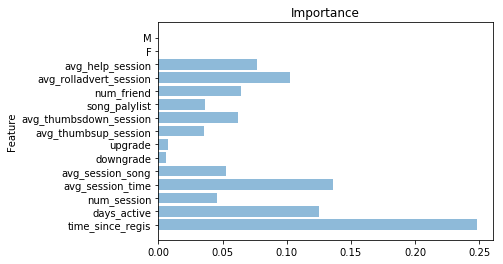

In [68]:
y_pos = np.arange(len(cols))


plt.barh(y_pos, imp_list, align='center', alpha=0.5)
plt.yticks(y_pos, cols)
plt.ylabel('Feature')
plt.title('Importance')

plt.show()

In [56]:
cvModel_gbt.bestModel.write().overwrite().save('GBTClassifier')

In [81]:
cvModel_gbt.bestModel.extractParamMap()


{Param(parent='GBTClassifier_bb02b1fa99e6', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='GBTClassifier_bb02b1fa99e6', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='GBTClassifier_bb02b1fa99e6', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'all',
 Param(parent='GBTClassifier_bb02b1fa99e6', name='featuresCol', doc='features column name'): 'features',
 Param(parent='GBTClassifier_bb02b1fa99e6', name='labelCol', doc='label column name'): 'la

In [82]:
#apply the optimized model on the whole dataset
gbt_optimal = GBTClassifier(maxIter=10,maxDepth = 5)
model = gbt_optimal.fit(data)

In [83]:
# save the model
model.write().overwrite().save('GBTClassifier')

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.